In [1]:
import math
import numpy as np
import scipy.stats as stats
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn
import pandas
import matplotlib as mpl

%matplotlib inline

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

params = {
   'font.size'           : SMALL_SIZE,
   'legend.fontsize'     : SMALL_SIZE,
   'xtick.labelsize'     : SMALL_SIZE,
   'ytick.labelsize'     : SMALL_SIZE,
   'legend.fontsize'     : SMALL_SIZE,
   'axes.labelsize'      : MEDIUM_SIZE,
   'axes.titlesize'      : MEDIUM_SIZE,
   'figure.titlesize'    : BIGGER_SIZE,
   'figure.autolayout'   : True,
   'font.family'         : 'sans-serif',
   'font.serif'          : 'DejaVu Sans',
   #'text.usetex'        : False,
   'figure.figsize'      : [5, 3]
   }
mpl.rcParams.update(params)
#mpl.use('pdf')

np.random.seed(1)

#Box-Mueller algorithm
def box_mueller(z0, sigma, n):
    z1 = np.zeros(n)
    
    for i in range(n):
        x = np.random.rand(2)
        y1 = math.sqrt(-2*np.log(x[0]))*np.cos(2*math.pi*x[1])
        z1[i] = z0 + y1*sigma
        
    return z1

/home/jeremy/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


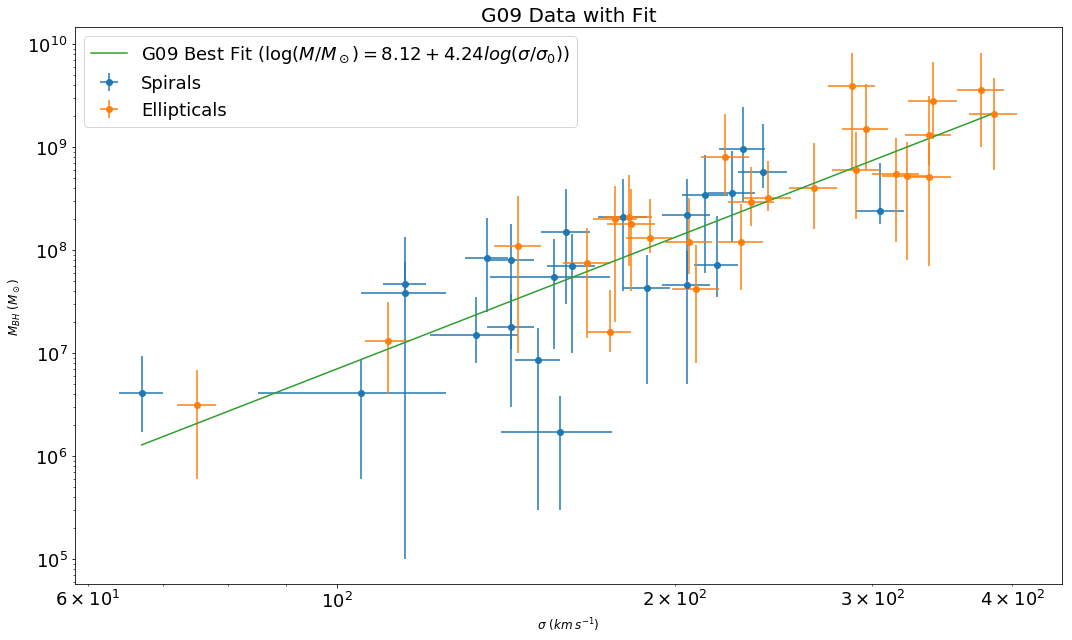

In [3]:
# DATA FROM GULTEKIN ET AL. (2009)

# create Table
tab = Table.read('/media/jeremy/DATA/JeremyDATA/Arizona/Astro513/A513_project/table.tex')

# split data into galaxy types
sigma_spirals = []
sigma_ellipticals = []
sigma_err_spirals = []
sigma_err_ellipticals = []
M_spirals = []
M_ellipticals = []
M_low_spirals = []
M_low_ellipticals = []
M_high_spirals = []
M_high_ellipticals = []

# read table
for i in range(len(tab["Galaxy"])):
    # get data values
    sigma = float(tab["sigma"][i][1:-1])
    sigma_err = float(tab["sigma_err"][i][1:-1].replace("$\\tablenotemark{d", ""))
    M_BH = float(tab["M_BH"][i][1:-2].replace("\\times10^{", "e"))
    M_low = float(tab["M_low"][i][1:-2].replace("\\times10^{", "e"))
    M_high = float(tab["M_high"][i][1:-2].replace("\\times10^{", "e"))
    
    #if spiral and not elliptical
    if tab["Type"][i].find("S") != -1 and tab["Type"][i].find("E") == -1:
        sigma_spirals.append(sigma)
        sigma_err_spirals.append(sigma_err)
        M_spirals.append(M_BH)
        M_low_spirals.append(M_low)
        M_high_spirals.append(M_high)
        
    #elif elliptical and not spiral
    elif tab["Type"][i].find("S") == -1 and tab["Type"][i].find("E") != -1:
        sigma_ellipticals.append(sigma)
        sigma_err_ellipticals.append(sigma_err)
        M_ellipticals.append(M_BH)
        M_low_ellipticals.append(M_low)
        M_high_ellipticals.append(M_high)
            
# change lists to numpy arrays for calculation ease
M_spirals = np.array(M_spirals)
sigma_spirals = np.array(sigma_spirals)
M_ellipticals = np.array(M_ellipticals)
sigma_ellipticals = np.array(sigma_ellipticals)

# plot data in log space to see power law
plt.figure(figsize=(15,9))
plt.errorbar(sigma_spirals, M_spirals, [M_low_spirals, M_high_spirals], sigma_err_spirals, "o", label="Spirals")
plt.errorbar(sigma_ellipticals, M_ellipticals, [M_low_ellipticals, M_high_ellipticals], sigma_err_ellipticals, "o", label="Ellipticals")
xx = np.linspace(np.amin(sigma_spirals), np.amax(sigma_ellipticals), 100)
plt.plot(xx, 0.0231*xx**4.24, label=r"G09 Best Fit $(\log(M/M_\odot) = 8.12 + 4.24 log(\sigma/\sigma_0))$")
plt.xscale("Log")
plt.yscale("Log")
plt.ylabel("$M_{BH}$ $(M_\odot)$", fontsize='large')
plt.xlabel("$\sigma$ $(km \: s^{-1})$", fontsize='large')
plt.legend()
plt.title("G09 Data with Fit")
plt.show()

dataset = "G09"

/home/jeremy/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


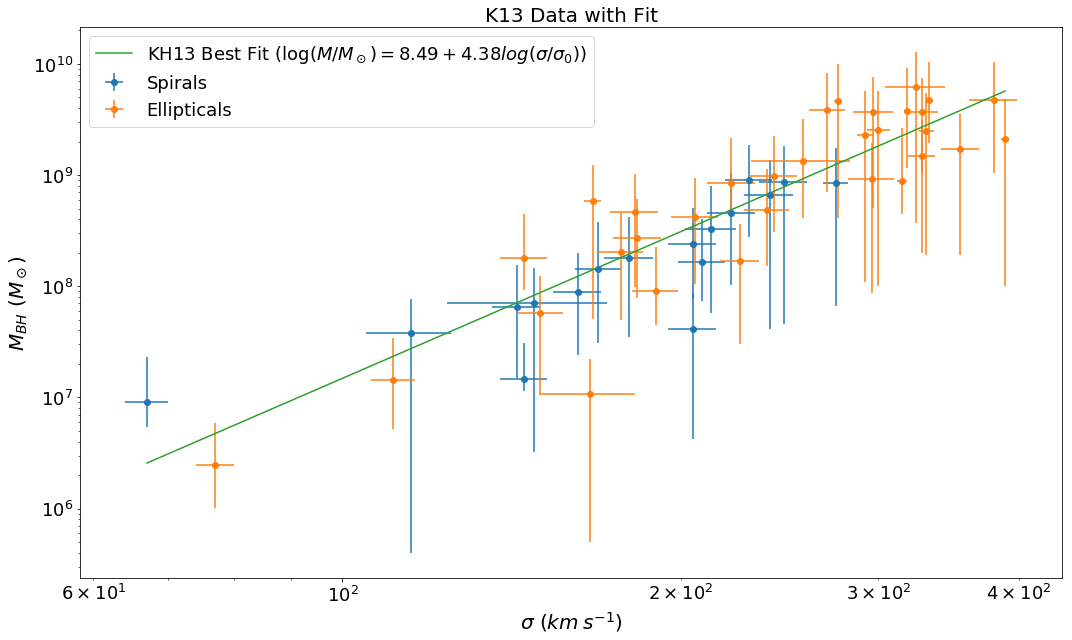

In [2]:
# DATA FROM KORMENDY & HO (2013)

# create Table
M_ellipticals, M_low_ellipticals, M_high_ellipticals, sigma_ellipticals, sigma_err_ellipticals = np.loadtxt('/media/jeremy/DATA/JeremyDATA/Arizona/Astro513/A513_project/table2E.dat', unpack=True, usecols=(13,14,15,16,18))
M_spirals, M_low_spirals, M_high_spirals, sigma_spirals, sigma_err_spirals = np.loadtxt('/media/jeremy/DATA/JeremyDATA/Arizona/Astro513/A513_project/table2SC.dat', unpack=True, usecols=(19,20,21,22,24))

# plot data in log space to see power law
plt.figure(figsize=(15,9))
plt.errorbar(sigma_spirals, M_spirals, [M_low_spirals, M_high_spirals], sigma_err_spirals, "o", label="Spirals")
plt.errorbar(sigma_ellipticals, M_ellipticals, [M_low_ellipticals, M_high_ellipticals], sigma_err_ellipticals, "o", label="Ellipticals")
xx = np.linspace(np.amin(sigma_spirals), np.amax(sigma_ellipticals), 100)
plt.plot(xx, 0.0258*xx**4.38, label=r"KH13 Best Fit $(\log(M/M_\odot) = 8.49 + 4.38 log(\sigma/\sigma_0))$")
plt.xscale("Log")
plt.yscale("Log")
plt.ylabel("$M_{BH}$ $(M_\odot)$")
plt.xlabel("$\sigma$ $(km \: s^{-1})$")
plt.legend()
plt.title("K13 Data with Fit")
plt.show()

dataset = "K13"

-0.0595948477926256 1.2024511114159016
3.6528155764028374 0.533289106819038


/home/jeremy/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


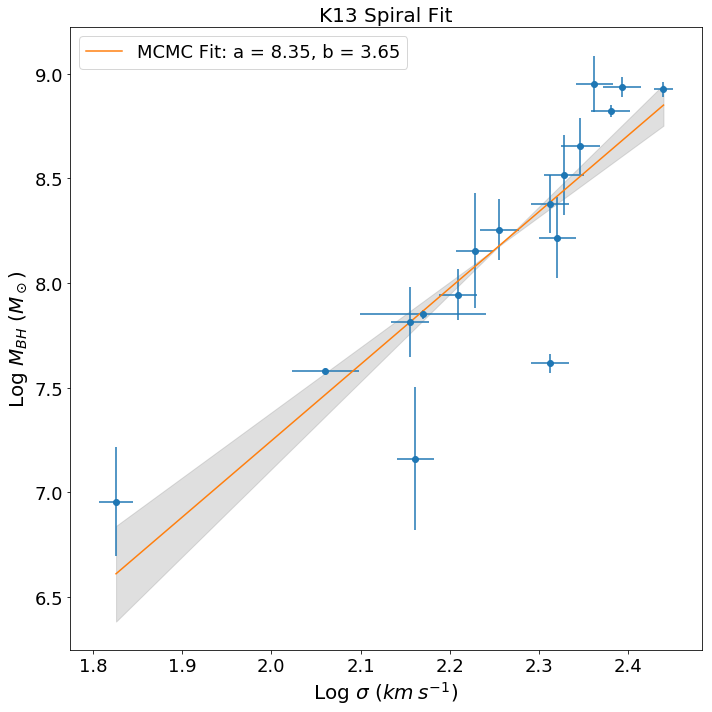

-2.3297511471571255 0.8590013597265399
4.693629952265136 0.3607650055235125


/home/jeremy/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


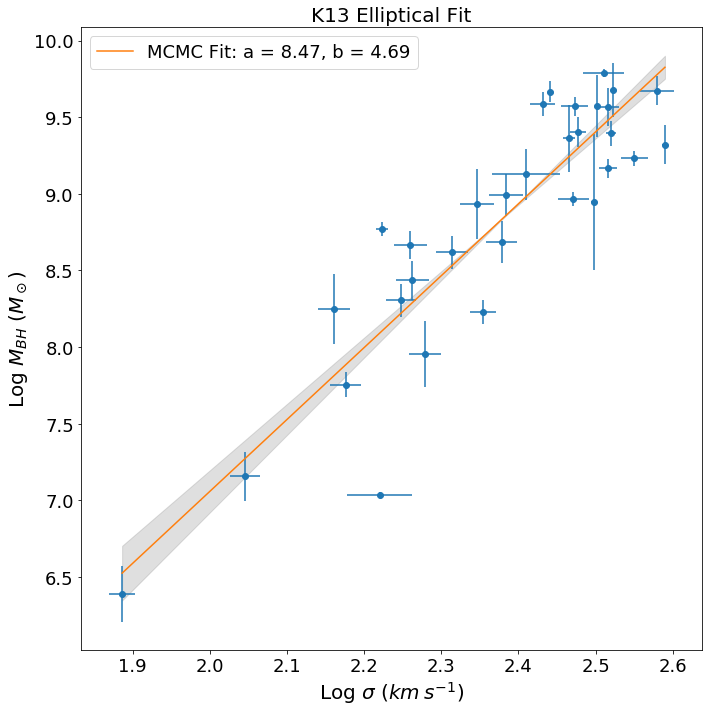

-1.9228269464152308 0.6339000022043633
4.50825278346856 0.2713138593337124


/home/jeremy/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


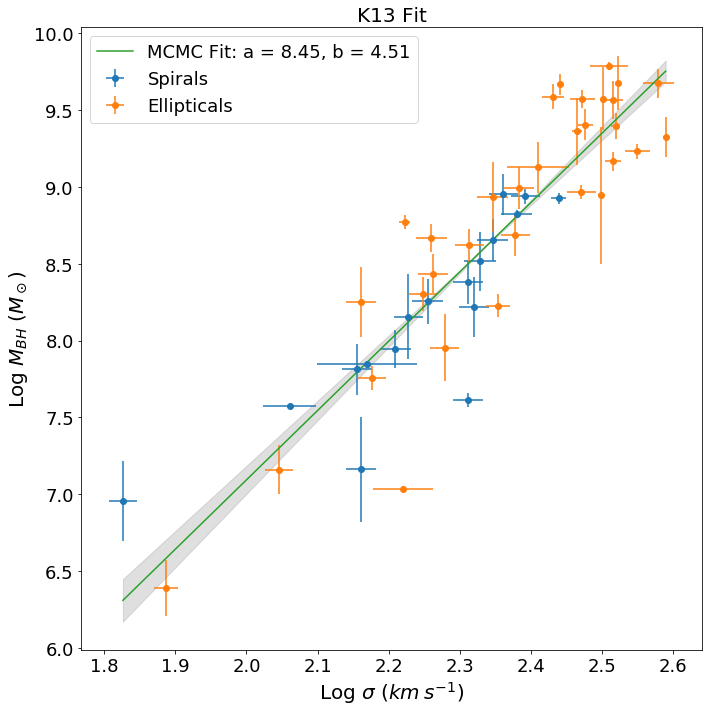

In [6]:
np.random.seed(1)

# set up the data sets for fitting line in log space, including error propagation
# spirals
y1 = np.log10(M_spirals)
y1_best_err = np.array([max(M_spirals[i] - M_low_spirals[i], M_high_spirals[i] - M_spirals[i]) for i in range(len(M_spirals))])
y1_err = y1_best_err/(M_spirals*np.log(10))
x1 = np.log10(sigma_spirals)
x1_err = sigma_err_spirals/(sigma_spirals*np.log(10))

# ellipticals
y2 = np.log10(M_ellipticals)
y2_best_err = np.array([max(M_ellipticals[i] - M_low_ellipticals[i], M_high_ellipticals[i] - M_ellipticals[i]) for i in range(len(M_ellipticals))])
y2_err = y2_best_err/(M_ellipticals*np.log(10))
x2 = np.log10(sigma_ellipticals)
x2_err = sigma_err_ellipticals/(sigma_ellipticals*np.log(10))

# combined
M = np.append(M_ellipticals, M_spirals)
M_low = np.append(M_low_ellipticals, M_low_spirals)
M_high = np.append(M_high_ellipticals, M_high_spirals)
sigma = np.append(sigma_ellipticals, sigma_spirals)
sigma_err = np.append(sigma_err_ellipticals, sigma_err_spirals)

y3 = np.log10(M)
y3_best_err = np.array([max(M[i] - M_low[i], M_high[i] - M[i]) for i in range(len(M))])
y3_err = y3_best_err/(M*np.log(10))
x3 = np.log10(sigma)
x3_err = sigma_err/(sigma*np.log(10))

# set up variances here for ease of calculation
# measured variances
y1_err2 = y1_err**2
y2_err2 = y2_err**2
y3_err2 = y3_err**2
x1_err2 = x1_err**2
x2_err2 = x2_err**2
x3_err2 = x3_err**2

# mean variances
y1_err2 = np.ones(len(y1_err))*(np.mean(y1_err)**2)
y2_err2 = np.ones(len(y2_err))*(np.mean(y2_err)**2)
y3_err2 = np.ones(len(y3_err))*(np.mean(y3_err)**2)
x1_err2 = np.ones(len(x1_err))*(np.mean(x1_err)**2)
x2_err2 = np.ones(len(x2_err))*(np.mean(x2_err)**2)
x3_err2 = np.ones(len(x3_err))*(np.mean(x3_err)**2)

# add intrinsic scatter
scatter = 0.285**2
y1_err2 += scatter
y2_err2 += scatter
y3_err2 += scatter

# create covariance matrices
sigma_xy1 = np.ones(len(x1))*(np.sum(x1 - np.mean(x1)))*(np.sum(y1 - np.mean(y1)))/(len(x1) - 1)
sigma_xy2 = np.ones(len(x2))*(np.sum(x2 - np.mean(x2)))*(np.sum(y2 - np.mean(y2)))/(len(x2) - 1)
sigma_xy3 = np.ones(len(x3))*(np.sum(x3 - np.mean(x3)))*(np.sum(y3 - np.mean(y3)))/(len(x3) - 1)
S1 = np.array([[(x1_err2[j], sigma_xy1[j]), (sigma_xy1[j], y1_err2[j])] for j in range(len(x1))])
S2 = np.array([[(x2_err2[j], sigma_xy2[j]), (sigma_xy2[j], y2_err2[j])] for j in range(len(x2))])
S3 = np.array([[(x3_err2[j], sigma_xy3[j]), (sigma_xy3[j], y3_err2[j])] for j in range(len(x3))])

# set up MCMC to find best-fit parameters
a = np.log10(0.0245)
b = 4.3
#c = 0.1
N = 250000
ai = np.zeros(N)
bi = np.zeros(N)
#ci = np.zeros(N)
Li = np.zeros(N)
ai[0] = np.random.rand() + a - 0.5
bi[0] = np.random.rand() + b - 0.5
#ci[0] = np.random.rand()*0.1 + c - 0.05
delta1 = box_mueller(0, 0.05, N)
delta2 = box_mueller(0, 0.05, N)
#delta3 = box_mueller(0, 0.005, N)
accept_spirals = []

# run MCMC on spirals
for i in range(1,N):
    test = [ai[i-1] + delta1[i], bi[i-1] + delta2[i]]
    
    # use covariance for likelihood test
    v_test = (1/np.sqrt(1+test[1]**2))*np.array([-test[1], 1])
    v_old = (1/np.sqrt(1+bi[i-1]**2))*np.array([-bi[i-1], 1])
    Delta_test = np.array([np.dot(v_test, [x1[j], y1[j]]) - test[0]/np.sqrt(1+test[1]**2) for j in range(len(x1))])
    Delta_old = np.array([np.dot(v_old, [x1[j], y1[j]]) - ai[i-1]/np.sqrt(1+bi[i-1]**2) for j in range(len(x1))])
    Sigma2_test = np.array([np.matmul(np.matmul(v_test.T, S1[j]), v_test) for j in range(len(S1))])
    Sigma2_old = np.array([np.matmul(np.matmul(v_old.T, S1[j]), v_old) for j in range(len(S1))])
    P_test = -0.5*(np.sum(Delta_test**2/Sigma2_test))
    P_old = -0.5*(np.sum(Delta_old**2/Sigma2_old))

    if i == 1:
        Li[0] = P_old

    if P_test > P_old:
        accept_spirals.append(test)
        ai[i] = test[0]
        bi[i] = test[1]
        #ci[i] = test[2]
        Li[i] = P_test
        
    else:
        Li[i] = Li[i-1]
        r = np.random.rand()
        
        if np.log(r) < P_test - P_old:
            accept_spirals.append(test)
            ai[i] = test[0]
            bi[i] = test[1]
            #ci[i] = test[2]
            
        else:
            ai[i] = ai[i-1]
            bi[i] = bi[i-1]
            #ci[i] = ci[i-1]
"""
# check acceptance rate for good fit values and parameter chains for convergence
print(len(accept_spirals))
plt.plot(np.arange(len(ai)), ai)
plt.show()
plt.plot(np.arange(len(bi)), bi)
plt.show()
#plt.plot(np.arange(len(ci)), ci)
#plt.show()
plt.plot(np.arange(len(Li)), Li)
plt.show()
"""
print(np.mean(ai), np.std(ai))
print(np.mean(bi), np.std(bi))

# make M-sigma plot for spirals
plt.figure(figsize=(10,10))
plt.errorbar(x1, y1, y1_err, x1_err, "o")
xp = np.linspace(np.amin(x1), np.amax(x1), 100)
yp = np.mean(bi)*xp + np.mean(ai)
yp1 = np.array([min((np.mean(bi)-np.std(bi))*xp[i] + np.mean(ai) + np.std(ai), (np.mean(bi)+np.std(bi))*xp[i] + np.mean(ai) - np.std(ai)) for i in range(len(xp))])
yp2 = np.array([max((np.mean(bi)-np.std(bi))*xp[i] + np.mean(ai) + np.std(ai), (np.mean(bi)+np.std(bi))*xp[i] + np.mean(ai) - np.std(ai)) for i in range(len(xp))])
plt.plot(xp, yp, label="MCMC Fit: a = " + str(round(np.mean(ai) + np.log10(200**np.mean(bi)), 2)) + ", b = " + str(round(np.mean(bi), 2)))
plt.fill_between(xp, yp1, yp2, alpha=0.25, color='grey')
plt.xlabel("Log $\sigma$ $(km \: s^{-1})$")
plt.ylabel("Log $M_{BH}$ $(M_\odot)$")
plt.legend(loc=2)
plt.title(dataset + " Spiral Fit")
plt.show()

# reset MCMC variables
ai = np.zeros(N)
bi = np.zeros(N)
#ci = np.zeros(N)
Li = np.zeros(N)
ai[0] = np.random.rand() + a - 0.5
bi[0] = np.random.rand() + b - 0.5
#ci[0] = np.random.rand()*0.1 + c - 0.05
delta1 = box_mueller(0, 0.05, N)
delta2 = box_mueller(0, 0.05, N)
#delta3 = box_mueller(0, 0.005, N)
accept_ellipticals = []

# run MCMC on ellipticals
for i in range(1,N):
    test = [ai[i-1] + delta1[i], bi[i-1] + delta2[i]]
    
    # use covariance for likelihood test
    v_test = (1/np.sqrt(1+test[1]**2))*np.array([-test[1], 1])
    v_old = (1/np.sqrt(1+bi[i-1]**2))*np.array([-bi[i-1], 1])
    Delta_test = np.array([np.dot(v_test, [x2[j], y2[j]]) - test[0]/np.sqrt(1+test[1]**2) for j in range(len(x2))])
    Delta_old = np.array([np.dot(v_old, [x2[j], y2[j]]) - ai[i-1]/np.sqrt(1+bi[i-1]**2) for j in range(len(x2))])
    Sigma2_test = np.array([np.matmul(np.matmul(v_test.T, S2[j]), v_test) for j in range(len(S2))])
    Sigma2_old = np.array([np.matmul(np.matmul(v_old.T, S2[j]), v_old) for j in range(len(S2))])
    P_test = -0.5*(np.sum(Delta_test**2/Sigma2_test))
    P_old = -0.5*(np.sum(Delta_old**2/Sigma2_old))

    if i == 1:
        Li[0] = P_old

    if P_test > P_old:
        accept_ellipticals.append(test)
        ai[i] = test[0]
        bi[i] = test[1]
        #ci[i] = test[2]
        Li[i] = P_test
        
    else:
        Li[i] = Li[i-1]
        r = np.random.rand()
        
        if np.log(r) < P_test - P_old:
            accept_ellipticals.append(test)
            ai[i] = test[0]
            bi[i] = test[1]
            #ci[i] = test[2]
            
        else:
            ai[i] = ai[i-1]
            bi[i] = bi[i-1]
            #ci[i] = ci[i-1]
"""
# check acceptance rate for good fit values and parameter chains for convergence
print(len(accept_ellipticals))
plt.plot(np.arange(len(ai)), ai)
plt.show()
plt.plot(np.arange(len(bi)), bi)
plt.show()
#plt.plot(np.arange(len(ci)), ci)
#plt.show()
plt.plot(np.arange(len(Li)), Li)
plt.show()
"""
print(np.mean(ai), np.std(ai))
print(np.mean(bi), np.std(bi))

# make M-sigma plot for ellipticals
plt.figure(figsize=(10,10))
plt.errorbar(x2, y2, y2_err, x2_err, "o")
xp = np.linspace(np.amin(x2), np.amax(x2), 100)
yp = np.mean(bi)*xp + np.mean(ai)
yp1 = np.array([min((np.mean(bi)-np.std(bi))*xp[i] + np.mean(ai) + np.std(ai), (np.mean(bi)+np.std(bi))*xp[i] + np.mean(ai) - np.std(ai)) for i in range(len(xp))])
yp2 = np.array([max((np.mean(bi)-np.std(bi))*xp[i] + np.mean(ai) + np.std(ai), (np.mean(bi)+np.std(bi))*xp[i] + np.mean(ai) - np.std(ai)) for i in range(len(xp))])
plt.plot(xp, yp, label="MCMC Fit: a = " + str(round(np.mean(ai) + np.log10(200**np.mean(bi)), 2)) + ", b = " + str(round(np.mean(bi), 2)))
plt.fill_between(xp, yp1, yp2, alpha=0.25, color='grey')
plt.xlabel("Log $\sigma$ $(km \: s^{-1})$")
plt.ylabel("Log $M_{BH}$ $(M_\odot)$")
plt.legend(loc=2)
plt.title(dataset + " Elliptical Fit")
plt.show()

# reset MCMC variables
ai = np.zeros(N)
bi = np.zeros(N)
#ci = np.zeros(N)
Li = np.zeros(N)
ai[0] = np.random.rand() + a - 0.5
bi[0] = np.random.rand() + b - 0.5
#ci[0] = np.random.rand()*0.1 + c - 0.05
delta1 = box_mueller(0, 0.05, N)
delta2 = box_mueller(0, 0.05, N)
#delta3 = box_mueller(0, 0.005, N)
accept_combined = []

# run MCMC on combined
for i in range(1,N):
    test = [ai[i-1] + delta1[i], bi[i-1] + delta2[i]]
    
    # use covariance for likelihood test
    v_test = (1/np.sqrt(1+test[1]**2))*np.array([-test[1], 1])
    v_old = (1/np.sqrt(1+bi[i-1]**2))*np.array([-bi[i-1], 1])
    Delta_test = np.array([np.dot(v_test, [x3[j], y3[j]]) - test[0]/np.sqrt(1+test[1]**2) for j in range(len(x3))])
    Delta_old = np.array([np.dot(v_old, [x3[j], y3[j]]) - ai[i-1]/np.sqrt(1+bi[i-1]**2) for j in range(len(x3))])
    Sigma2_test = np.array([np.matmul(np.matmul(v_test.T, S3[j]), v_test) for j in range(len(S3))])
    Sigma2_old = np.array([np.matmul(np.matmul(v_old.T, S3[j]), v_old) for j in range(len(S3))])
    P_test = -0.5*(np.sum(Delta_test**2/Sigma2_test))
    P_old = -0.5*(np.sum(Delta_old**2/Sigma2_old))
    
    if i == 1:
        Li[0] = P_old

    if P_test > P_old:
        accept_combined.append(test)
        ai[i] = test[0]
        bi[i] = test[1]
        #ci[i] = test[2]
        Li[i] = P_test
        
    else:
        Li[i] = Li[i-1]
        r = np.random.rand()
        
        if np.log(r) < P_test - P_old:
            accept_combined.append(test)
            ai[i] = test[0]
            bi[i] = test[1]
            #ci[i] = test[2]
            
        else:
            ai[i] = ai[i-1]
            bi[i] = bi[i-1]
            #ci[i] = ci[i-1]
"""
# check acceptance rate for good fit values and parameter chains for convergence
print(len(accept_combined))
plt.plot(np.arange(len(ai)), ai)
plt.show()
plt.plot(np.arange(len(bi)), bi)
plt.show()
#plt.plot(np.arange(len(ci)), ci)
#plt.show()
plt.plot(np.arange(len(Li)), Li)
plt.show()
"""
print(np.mean(ai), np.std(ai))
print(np.mean(bi), np.std(bi))

# make M-sigma plot for combined
plt.figure(figsize=(10,10))
plt.errorbar(x1, y1, y1_err, x1_err, "o", label="Spirals")
plt.errorbar(x2, y2, y2_err, x2_err, "o", label="Ellipticals")
xp = np.linspace(np.amin(x3), np.amax(x3), 100)
yp = np.mean(bi)*xp + np.mean(ai)
yp1 = np.array([min((np.mean(bi)-np.std(bi))*xp[i] + np.mean(ai) + np.std(ai), (np.mean(bi)+np.std(bi))*xp[i] + np.mean(ai) - np.std(ai)) for i in range(len(xp))])
yp2 = np.array([max((np.mean(bi)-np.std(bi))*xp[i] + np.mean(ai) + np.std(ai), (np.mean(bi)+np.std(bi))*xp[i] + np.mean(ai) - np.std(ai)) for i in range(len(xp))])
plt.plot(xp, yp, label="MCMC Fit: a = " + str(round(np.mean(ai) + np.log10(200**np.mean(bi)), 2)) + ", b = " + str(round(np.mean(bi), 2)))
plt.fill_between(xp, yp1, yp2, alpha=0.25, color='grey')
plt.xlabel("Log $\sigma$ $(km \: s^{-1})$")
plt.ylabel("Log $M_{BH}$ $(M_\odot)$")
plt.legend(loc=2)
plt.title(dataset + " Fit")
plt.show()

-0.0028695723893327097 1.3235007182368452
3.6276770676987193 0.5869086460353655


/home/jeremy/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


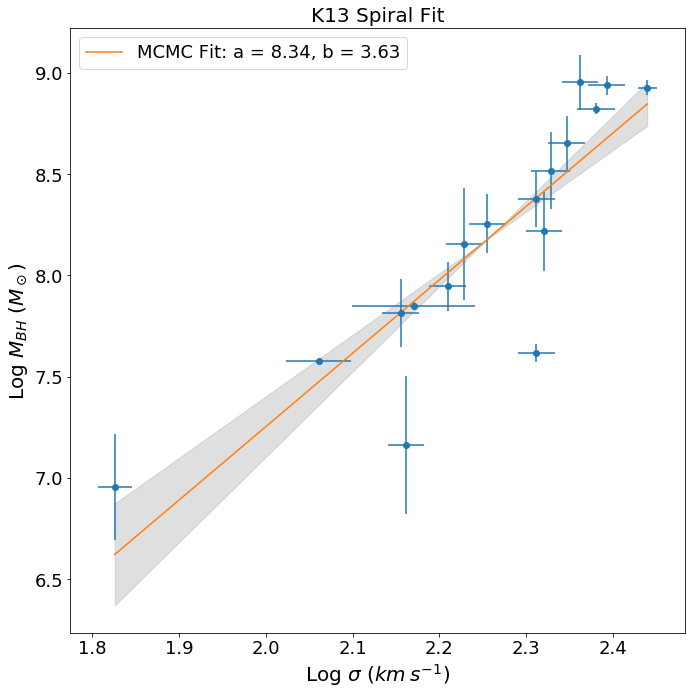

-2.2483196434044856 0.8277713704257502
4.65934822961096 0.3476747633745103


/home/jeremy/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


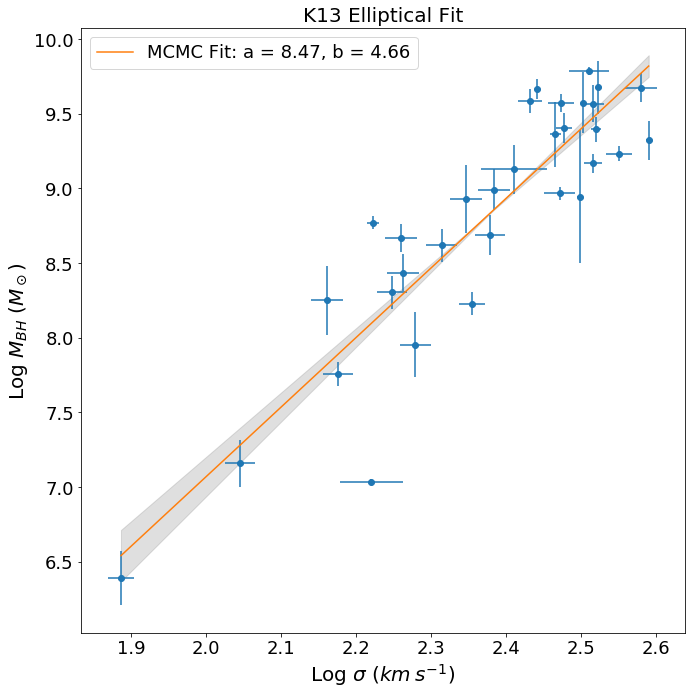

-1.8796309335934103 0.7127798864991571
4.48977687719747 0.3048423294422149


/home/jeremy/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


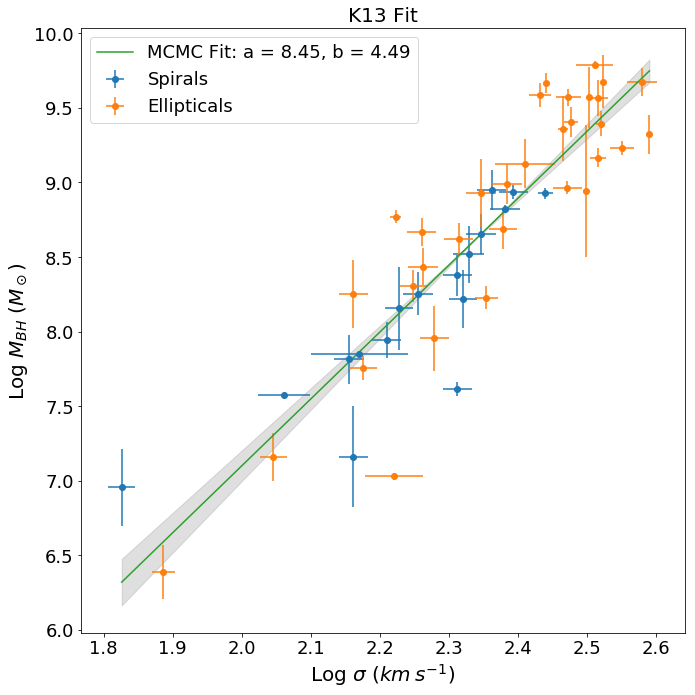

In [124]:
np.random.seed(1)

# set up the data sets for fitting line in log space, including error propagation
# spirals
y1 = np.log10(M_spirals)
y1_best_err = np.array([max(M_spirals[i] - M_low_spirals[i], M_high_spirals[i] - M_spirals[i]) for i in range(len(M_spirals))])
y1_err = y1_best_err/(M_spirals*np.log(10))
x1 = np.log10(sigma_spirals)
x1_err = sigma_err_spirals/(sigma_spirals*np.log(10))

# ellipticals
y2 = np.log10(M_ellipticals)
y2_best_err = np.array([max(M_ellipticals[i] - M_low_ellipticals[i], M_high_ellipticals[i] - M_ellipticals[i]) for i in range(len(M_ellipticals))])
y2_err = y2_best_err/(M_ellipticals*np.log(10))
x2 = np.log10(sigma_ellipticals)
x2_err = sigma_err_ellipticals/(sigma_ellipticals*np.log(10))

# combined
M = np.append(M_ellipticals, M_spirals)
M_low = np.append(M_low_ellipticals, M_low_spirals)
M_high = np.append(M_high_ellipticals, M_high_spirals)
sigma = np.append(sigma_ellipticals, sigma_spirals)
sigma_err = np.append(sigma_err_ellipticals, sigma_err_spirals)

y3 = np.log10(M)
y3_best_err = np.array([max(M[i] - M_low[i], M_high[i] - M[i]) for i in range(len(M))])
y3_err = y3_best_err/(M*np.log(10))
x3 = np.log10(sigma)
x3_err = sigma_err/(sigma*np.log(10))

# set up variances here for ease of calculation
# measured variances
y1_err2 = y1_err**2
y2_err2 = y2_err**2
y3_err2 = y3_err**2
x1_err2 = x1_err**2
x2_err2 = x2_err**2
x3_err2 = x3_err**2

# mean variances
y1_err2 = np.ones(len(y1_err))*(np.mean(y1_err)**2)
y2_err2 = np.ones(len(y2_err))*(np.mean(y2_err)**2)
y3_err2 = np.ones(len(y3_err))*(np.mean(y3_err)**2)
x1_err2 = np.ones(len(x1_err))*(np.mean(x1_err)**2)
x2_err2 = np.ones(len(x2_err))*(np.mean(x2_err)**2)
x3_err2 = np.ones(len(x3_err))*(np.mean(x3_err)**2)

# add intrinsic scatter
scatter = 0.285**2
y1_err2 += scatter
y2_err2 += scatter
y3_err2 += scatter

# set up MCMC to find best-fit parameters
a = np.log10(0.0258)
b = 4.377
#c = 0.3
N = 1000000
ai = np.zeros(N)
bi = np.zeros(N)
#ci = np.zeros(N)
Li = np.zeros(N)
ai[0] = np.random.rand() + a - 0.5
bi[0] = np.random.rand() + b - 0.5
#ci[0] = np.random.rand()*0.1 + c - 0.05
delta1 = box_mueller(0, 0.02, N)
delta2 = box_mueller(0, 0.02, N)
#delta3 = box_mueller(0, 0.002, N)
accept_spirals = []

# run MCMC on spirals
for i in range(1,N):
    test = [ai[i-1] + delta1[i], bi[i-1] + delta2[i]]
    P_test = -0.5*np.sum((y1 - test[0] - test[1]*x1)**2/(y1_err2 + test[1]**2*x1_err2)) - np.log(np.sqrt(test[1]))
    P_old = -0.5*np.sum((y1 - ai[i-1] - bi[i-1]*x1)**2/(y1_err2 + bi[i-1]**2*x1_err2)) - np.log(np.sqrt(bi[i-1]))
    
    if i == 1:
        Li[0] = P_old

    if P_test > P_old:
        accept_spirals.append(test)
        ai[i] = test[0]
        bi[i] = test[1]
        #ci[i] = test[2]
        Li[i] = P_test
        
    else:
        Li[i] = Li[i-1]
        r = np.random.rand()
        
        if np.log(r) < P_test - P_old:
            accept_spirals.append(test)
            ai[i] = test[0]
            bi[i] = test[1]
            #ci[i] = test[2]
            
        else:
            ai[i] = ai[i-1]
            bi[i] = bi[i-1]
            #ci[i] = ci[i-1]
"""
# check acceptance rate for good fit values and parameter chains for convergence
print(len(accept_spirals))
plt.plot(np.arange(len(ai)), ai)
plt.show()
plt.plot(np.arange(len(bi)), bi)
plt.show()
plt.plot(np.arange(len(ci)), ci)
plt.show()
plt.plot(np.arange(len(Li)), Li)
plt.show()
"""
print(np.mean(ai), np.std(ai))
print(np.mean(bi), np.std(bi))

# make M-sigma plot for spirals
f = plt.figure(figsize=(10,10))
plt.errorbar(x1, y1, y1_err, x1_err, "o")
xp = np.linspace(np.amin(x1), np.amax(x1), 100)
yp = np.mean(bi)*xp + np.mean(ai)
yp1 = np.array([min((np.mean(bi)-np.std(bi))*xp[i] + np.mean(ai) + np.std(ai), (np.mean(bi)+np.std(bi))*xp[i] + np.mean(ai) - np.std(ai)) for i in range(len(xp))])
yp2 = np.array([max((np.mean(bi)-np.std(bi))*xp[i] + np.mean(ai) + np.std(ai), (np.mean(bi)+np.std(bi))*xp[i] + np.mean(ai) - np.std(ai)) for i in range(len(xp))])
plt.plot(xp, yp, label="MCMC Fit: a = " + str(round(np.mean(ai) + np.log10(200**np.mean(bi)), 2)) + ", b = " + str(round(np.mean(bi), 2)))
plt.fill_between(xp, yp1, yp2, alpha=0.25, color='grey')
plt.xlabel("Log $\sigma$ $(km \: s^{-1})$")
plt.ylabel("Log $M_{BH}$ $(M_\odot)$")
plt.legend(loc=2)
plt.title(dataset + " Spiral Fit")
plt.show()

# reset MCMC variables
ai = np.zeros(N)
bi = np.zeros(N)
#ci = np.zeros(N)
Li = np.zeros(N)
ai[0] = np.random.rand() + a - 0.5
bi[0] = np.random.rand() + b - 0.5
#ci[0] = np.random.rand()*0.1 + c - 0.05
delta1 = box_mueller(0, 0.02, N)
delta2 = box_mueller(0, 0.02, N)
#delta3 = box_mueller(0, 0.005, N)
accept_ellipticals = []

# run MCMC on ellipticals
for i in range(1,N):
    """
    test = [ai[i-1] + delta1[i], bi[i-1] + delta2[i], ci[i-1] + delta3[i]]
    P_test = -0.5*np.sum((y2 - test[0] - test[1]*x2)**2/(np.array(y2_err2 + test[2]**2) + test[1]**2*x2_err2)) - np.log(np.sqrt(test[1]))
    P_old = -0.5*np.sum((y2 - ai[i-1] - bi[i-1]*x2)**2/(np.array(y2_err2 + ci[i-1]**2) + bi[i-1]**2*x2_err2)) - np.log(np.sqrt(bi[i-1]))
    """
    test = [ai[i-1] + delta1[i], bi[i-1] + delta2[i]]
    P_test = -0.5*np.sum((y2 - test[0] - test[1]*x2)**2/(y2_err2 + test[1]**2*x2_err2)) - np.log(np.sqrt(test[1]))
    P_old = -0.5*np.sum((y2 - ai[i-1] - bi[i-1]*x2)**2/(y2_err2 + bi[i-1]**2*x2_err2)) - np.log(np.sqrt(bi[i-1]))
    
    if i == 1:
        Li[0] = P_old

    if P_test > P_old:
        accept_ellipticals.append(test)
        ai[i] = test[0]
        bi[i] = test[1]
        #ci[i] = test[2]
        Li[i] = P_test
        
    else:
        Li[i] = Li[i-1]
        r = np.random.rand()
        
        if np.log(r) < P_test - P_old:
            accept_ellipticals.append(test)
            ai[i] = test[0]
            bi[i] = test[1]
            #ci[i] = test[2]
            
        else:
            ai[i] = ai[i-1]
            bi[i] = bi[i-1]
            #ci[i] = ci[i-1]
"""
# check acceptance rate for good fit values and parameter chains for convergence
print(len(accept_ellipticals))
plt.plot(np.arange(len(ai)), ai)
plt.show()
plt.plot(np.arange(len(bi)), bi)
plt.show()
#plt.plot(np.arange(len(ci)), ci)
#plt.show()
plt.plot(np.arange(len(Li)), Li)
plt.show()
"""
print(np.mean(ai), np.std(ai))
print(np.mean(bi), np.std(bi))

# make M-sigma plot for ellipticals
f = plt.figure(figsize=(10,10))
plt.errorbar(x2, y2, y2_err, x2_err, "o")
xp = np.linspace(np.amin(x2), np.amax(x2), 100)
yp = np.mean(bi)*xp + np.mean(ai)
yp1 = np.array([min((np.mean(bi)-np.std(bi))*xp[i] + np.mean(ai) + np.std(ai), (np.mean(bi)+np.std(bi))*xp[i] + np.mean(ai) - np.std(ai)) for i in range(len(xp))])
yp2 = np.array([max((np.mean(bi)-np.std(bi))*xp[i] + np.mean(ai) + np.std(ai), (np.mean(bi)+np.std(bi))*xp[i] + np.mean(ai) - np.std(ai)) for i in range(len(xp))])
plt.plot(xp, yp, label="MCMC Fit: a = " + str(round(np.mean(ai) + np.log10(200**np.mean(bi)), 2)) + ", b = " + str(round(np.mean(bi), 2)))
plt.fill_between(xp, yp1, yp2, alpha=0.25, color='grey')
plt.xlabel("Log $\sigma$ $(km \: s^{-1})$")
plt.ylabel("Log $M_{BH}$ $(M_\odot)$")
plt.legend(loc=2)
plt.title(dataset + " Elliptical Fit")
plt.show()

# reset MCMC variables
ai = np.zeros(N)
bi = np.zeros(N)
#ci = np.zeros(N)
Li = np.zeros(N)
ai[0] = np.random.rand() + a - 0.5
bi[0] = np.random.rand() + b - 0.5
#ci[0] = np.random.rand()*0.1 + c - 0.05
delta1 = box_mueller(0, 0.02, N)
delta2 = box_mueller(0, 0.02, N)
#delta3 = box_mueller(0, 0.005, N)
accept_combined = []

# run MCMC on combined
for i in range(1,N):
    """
    test = [ai[i-1] + delta1[i], bi[i-1] + delta2[i], ci[i-1] + delta3[i]]
    P_test = -0.5*np.sum((y2 - test[0] - test[1]*x2)**2/(np.array(y2_err2 + test[2]**2) + test[1]**2*x2_err2)) - np.log(np.sqrt(test[1]))
    P_old = -0.5*np.sum((y2 - ai[i-1] - bi[i-1]*x2)**2/(np.array(y2_err2 + ci[i-1]**2) + bi[i-1]**2*x2_err2)) - np.log(np.sqrt(bi[i-1]))
    """
    test = [ai[i-1] + delta1[i], bi[i-1] + delta2[i]]
    P_test = -0.5*np.sum((y3 - test[0] - test[1]*x3)**2/(y3_err2 + test[1]**2*x3_err2)) - np.log(np.sqrt(test[1]))
    P_old = -0.5*np.sum((y3 - ai[i-1] - bi[i-1]*x3)**2/(y3_err2 + bi[i-1]**2*x3_err2)) - np.log(np.sqrt(bi[i-1]))
    
    if i == 1:
        Li[0] = P_old

    if P_test > P_old:
        accept_combined.append(test)
        ai[i] = test[0]
        bi[i] = test[1]
        #ci[i] = test[2]
        Li[i] = P_test
        
    else:
        Li[i] = Li[i-1]
        r = np.random.rand()
        
        if np.log(r) < P_test - P_old:
            accept_combined.append(test)
            ai[i] = test[0]
            bi[i] = test[1]
            #ci[i] = test[2]
            
        else:
            ai[i] = ai[i-1]
            bi[i] = bi[i-1]
            #ci[i] = ci[i-1]
"""
# check acceptance rate for good fit values and parameter chains for convergence
print(len(accept_combined))
plt.plot(np.arange(len(ai)), ai)
plt.show()
plt.plot(np.arange(len(bi)), bi)
plt.show()
#plt.plot(np.arange(len(ci)), ci)
#plt.show()
plt.plot(np.arange(len(Li)), Li)
plt.show()
"""
print(np.mean(ai), np.std(ai))
print(np.mean(bi), np.std(bi))

# make M-sigma plot for combined
f = plt.figure(figsize=(10,10))
plt.errorbar(x1, y1, y1_err, x1_err, "o", label="Spirals")
plt.errorbar(x2, y2, y2_err, x2_err, "o", label="Ellipticals")
xp = np.linspace(np.amin(x3), np.amax(x3), 100)
yp = np.mean(bi)*xp + np.mean(ai)
yp1 = np.array([min((np.mean(bi)-np.std(bi))*xp[i] + np.mean(ai) + np.std(ai), (np.mean(bi)+np.std(bi))*xp[i] + np.mean(ai) - np.std(ai)) for i in range(len(xp))])
yp2 = np.array([max((np.mean(bi)-np.std(bi))*xp[i] + np.mean(ai) + np.std(ai), (np.mean(bi)+np.std(bi))*xp[i] + np.mean(ai) - np.std(ai)) for i in range(len(xp))])
plt.plot(xp, yp, label="MCMC Fit: a = " + str(round(np.mean(ai) + np.log10(200**np.mean(bi)), 2)) + ", b = " + str(round(np.mean(bi), 2)))
plt.fill_between(xp, yp1, yp2, alpha=0.25, color='grey')
plt.xlabel("Log $\sigma$ $(km \: s^{-1})$")
plt.ylabel("Log $M_{BH}$ $(M_\odot)$")
plt.legend(loc=2)
plt.title(dataset + " Fit")
plt.show()